In [15]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.tbats import TBATS
from darts.models import BlockRNNModel
import numpy as np
import math
from dateutil.relativedelta import relativedelta
from pmdarima.arima import auto_arima
from sklearn.ensemble import RandomForestRegressor

In [37]:
class randomForestmodel:
    def __init__(self,train):
        train = train.copy()
        self.last = train.values.ravel()[-1]
        self.start_date = train.index[-1] + relativedelta(months = 1)
        # train = train.diff().dropna()
        train['mes'] = train.index.month
        train['quarter'] = train.index.quarter
        train['ano'] = train.index.year
        x_values = train[['mes','quarter','ano']].values
        y_train = train.drop(['mes','quarter','ano'],axis = 1).values.ravel()
        self.model = RandomForestRegressor(max_depth=100, random_state=0).fit(x_values,y_train)
    def predict(self,n):
        datas = pd.date_range(start = self.start_date,periods = n,freq = 'm')
        x_df = pd.DataFrame(index = datas)
        x_df['mes'] = x_df.index.month
        x_df['quarter'] = x_df.index.quarter
        x_df['ano'] = x_df.index.year
        x_values = x_df.values
        return self.model.predict(x_values)

In [38]:
class ARIMAmodel:
    def __init__(self,train):
        self.model = auto_arima(train, start_p=1, start_q=1,
                        test='adf',
                        max_p=5, max_q=5,
                        m=1,             
                        d=1,          
                        seasonal=True,   
                        start_P=0, 
                        D=None, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    def predict(self,n):
        return self.model.predict(n_periods=n)

In [39]:
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

In [40]:
def predict_energy_production(test = False,lags = None):
    df = pd.read_csv('daily_eletricity_generation_by_source_brazil.csv',index_col = 'date',parse_dates = True)
    df = df.resample('m').sum()
    if not test:
        lags = [5]
    results = {}
    for anos in lags:
        y_train = df.iloc[:-12 * anos]
        model = randomForestmodel(y_train[['hydroeletric']])
        prediction = model.predict(12 * anos)
        pred_df = df[['hydroeletric']].copy()
        pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
        results[anos] = pred_df
    if test:
        return results
    pred_df['res'] = ((pred_df['hydroeletric'] - pred_df['prediction']) / pred_df['hydroeletric']).apply(abs)
    pred = pred_df.dropna()
    std = math.sqrt(np.square(pred['hydroeletric'].values - pred['prediction'].values).sum())
    res_max = pred['res'].max()
    # Treinando novamente o modelo e calculando o Forecast
    model = randomForestmodel(df[['hydroeletric']])
    prediction = model.predict(12 * anos)
    pred_df = pd.DataFrame({'prediction':prediction},
        index = pd.period_range(start = df.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))
    pred_df['superior'] = [pred + (pred * res_max) for pred in prediction]
    pred_df['inferior'] = [pred - (pred * res_max) for pred in prediction]
    pred_df['std'] = std

<AxesSubplot:xlabel='date'>

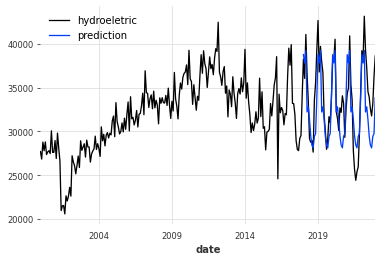

In [49]:
lag = 5
pred = predict_energy_production(True,[lag])
pred[lag].plot()